In [16]:
import pandas as pd
from siuba import *
from siuba.siu import call
from plotnine import *
import json
import matplotlib.pyplot as pp
import tidytext

In [17]:
# load all the data
commits_raw = pd.read_pickle("../data/graphql/commits_total.pkl")
commits_df = pd.DataFrame()
for repo in commits_raw:
    commits_df = pd.concat([commits_df, pd.DataFrame(repo)])

In [18]:
issues_total = pd.read_pickle("../data/graphql/issues_total.pkl")
issuespr_total = pd.read_pickle("../data/graphql/issuespr_total.pkl")
issues_df = pd.concat((pd.DataFrame(issues_total), pd.DataFrame(issuespr_total)))

In [19]:
with open("../data/repos/topic_combined.json", "r") as read_file:
    raw = json.load(read_file)
repo_df = pd.DataFrame(raw)

In [20]:
nonone = (repo_df 
    >> select(_.description)
    >> filter(-_.description.isin([None])))

In [21]:
import string
import random
import nltk
from nltk.corpus import reuters
from nltk import FreqDist
from nltk import ngrams
  
# input the reuters sentences
sents  = nonone.description.to_list()

n = 4

fourgrams = ngrams(sents[0].split(), n)

for grams in fourgrams:
    print(grams)

('Learn', 'how', 'to', 'responsibly')
('how', 'to', 'responsibly', 'develop,')
('to', 'responsibly', 'develop,', 'deploy')
('responsibly', 'develop,', 'deploy', 'and')
('develop,', 'deploy', 'and', 'maintain')
('deploy', 'and', 'maintain', 'production')
('and', 'maintain', 'production', 'machine')
('maintain', 'production', 'machine', 'learning')
('production', 'machine', 'learning', 'applications.')


In [22]:
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [23]:
import re
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [24]:
# repo_df['nomoji'] = repo_df.apply(lambda row: remove_emojis(row['description']), axis = 1)

In [25]:
tokenizer = RegexpTokenizer(r'\w+')

# Vectorize document using TF-IDF
tfidf = TfidfVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize)

# Fit and Transform the documents
train_data = tfidf.fit_transform(sents)   

In [36]:
# Define the number of topics or components
num_components=10

# Create LDA object
model=LatentDirichletAllocation(n_components=num_components)

# Fit and Transform SVD model on data
lda_matrix = model.fit_transform(train_data)

# Get Components 
lda_components=model.components_

In [29]:
model._get_param_names()
# per topic per word
# per document per topic

['batch_size',
 'doc_topic_prior',
 'evaluate_every',
 'learning_decay',
 'learning_method',
 'learning_offset',
 'max_doc_update_iter',
 'max_iter',
 'mean_change_tol',
 'n_components',
 'n_jobs',
 'perp_tol',
 'random_state',
 'topic_word_prior',
 'total_samples',
 'verbose']

In [38]:
# Print the topics with their terms
terms = tfidf.get_feature_names_out()

for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:7]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

Topic 0:  ['learning', 'azure', 'example', 'mlops', 'machine', 'using', 'project']
Topic 1:  ['list', 'curated', 'open', 'source', 'awesome', 'ml', 'tools']
Topic 2:  ['end', 'model', 'kubeflow', 'cloud', 'learning', 'machine', 'mlops']
Topic 3:  ['platform', 'mlops', 'project', 'machine', 'learning', 'data', 'development']
Topic 4:  ['ci', 'cd', 'sagemaker', 'mlops', 'deploy', 'learning', 'model']
Topic 5:  ['data', 'mlops', 'ml', 'resources', 'practices', 'best', 'pipelines']
Topic 6:  ['feature', 'mlops', 'ml', 'data', 'collection', 'store', 'training']
Topic 7:  ['ml', 'datatalksclub', 'solution', 'python', 'using', 'docker', 'b']
Topic 8:  ['documentation', 'end', 'mlflow', 'mlops', 'learning', 'machine', 'examples']
Topic 9:  ['learning', 'mlops', 'machine', 'azure', 'data', 'engineering', 'course']


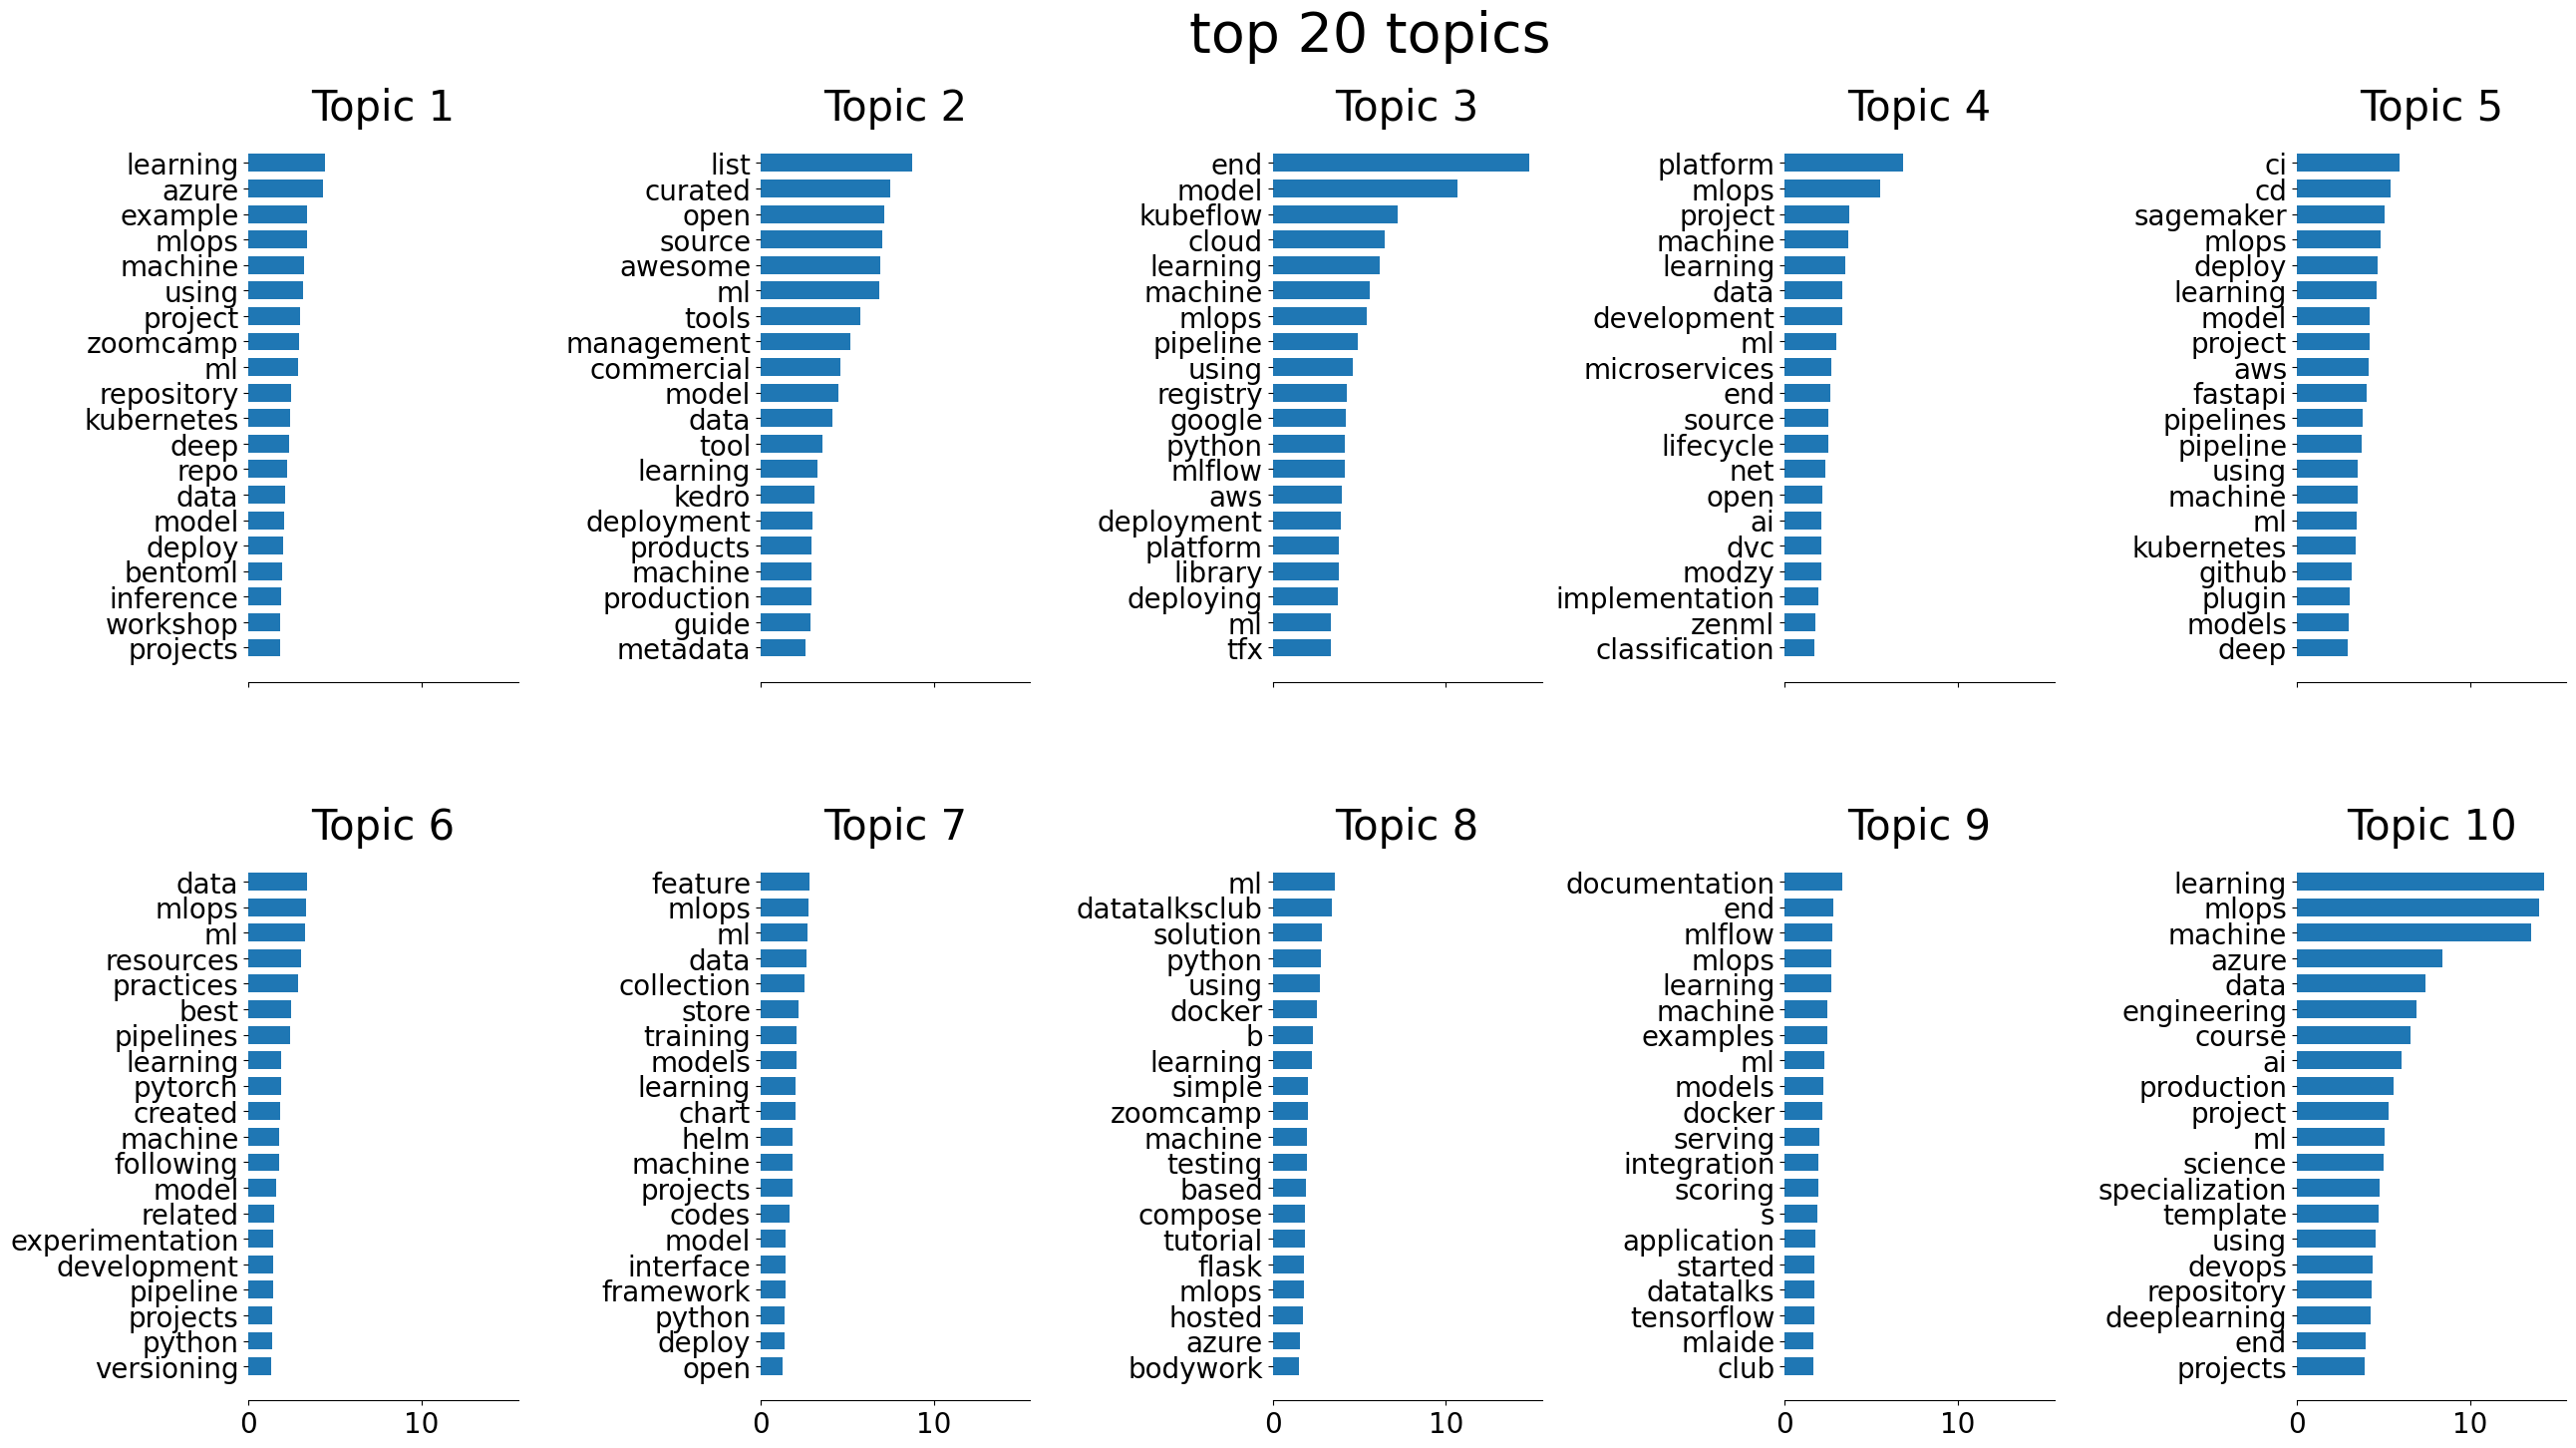

In [39]:
import matplotlib.pyplot as plt

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

plot_top_words(model, tfidf.get_feature_names_out(), 20, "top 20 topics")

In [40]:
from sklearn.cluster import KMeans

cluster = KMeans().fit(train_data)

In [42]:
cluster.get_params()

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 8,
 'n_init': 10,
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [ ]:
## correlation matrix of numeric variables

In [44]:
cluster.predict(train_data)

array([6, 0, 5, ..., 6, 0, 6], dtype=int32)